## Ingest dataset

In [31]:
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
    # Download the file from the URL
zipresp = urlopen(zipurl)
    # Create a new file on the hard drive
tempzip = open("/tmp/tmpfile.zip", "wb")
    # Write the contents of the downloaded file into the new file
tempzip.write(zipresp.read())
    # Close the newly-created file
tempzip.close()
    # Re-open the newly-created file with ZipFile()
zf = ZipFile("/tmp/tmpfile.zip")
    # Extract its contents into <extraction_path>
    # note that extractall will automatically create the path
zf.extractall(path = '/home/zhaoy426/FP/data/')
    # close the ZipFile instance
zf.close()

Create a Spark dataframe using the CSV file

### Data description
The following columns are included in the dataset:

#### Index column:
- instant: record index

#### Feature columns:
- dteday: date
- season: season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: year (0:2011, 1:2012)
- mnth: month (1 to 12)
- hr: hour (0 to 23)
- holiday: 1 if holiday, 0 otherwise
- weekday: day of the week (0 to 6)
- workingday: 0 if weekend or holiday, 1 otherwise
- weathersit: (1:clear, 2:mist or clouds, 3:light rain or snow, 4:heavy rain or snow)
- temp: normalized temperature in Celsius
- atemp: normalized feeling temperature in Celsius
- hum: normalized humidity
- windspeed: normalized wind speed

#### Label columns:
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## ML with Python

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
import time

In [33]:

day = pd.read_csv('/home/zhaoy426/FP/data/day.csv')
day.head()
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [34]:
hour = pd.read_csv('/home/zhaoy426/FP/data/hour.csv')
hour.head()
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


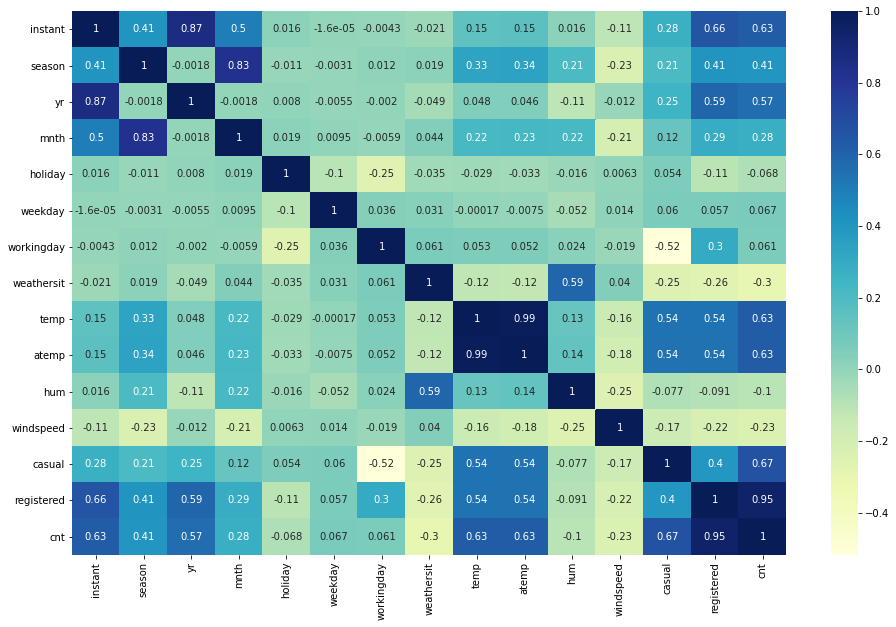

In [35]:
plt.figure(figsize = (16, 10))
sns.heatmap(day.corr(), annot = True, cmap="YlGnBu")
plt.show()

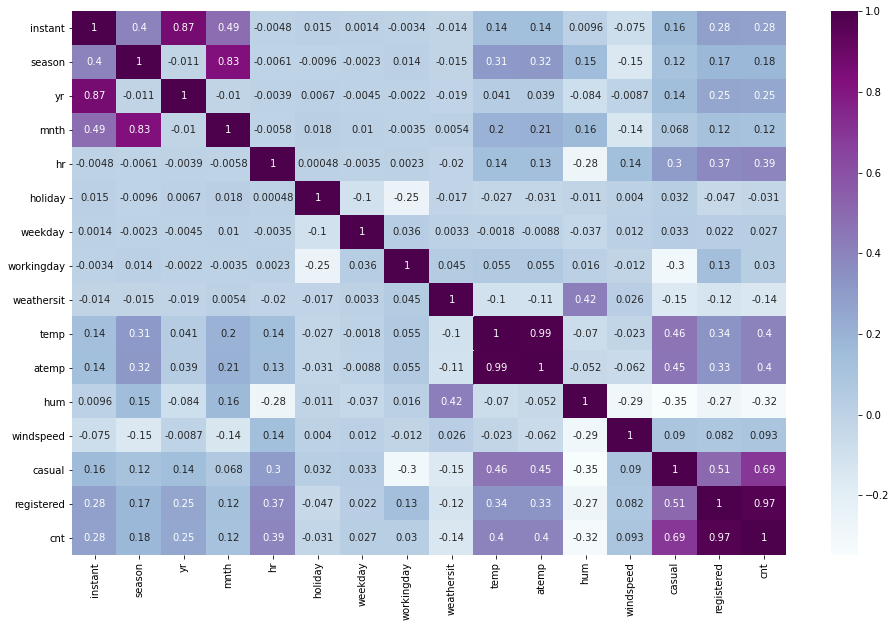

In [36]:
plt.figure(figsize = (16, 10))
sns.heatmap(hour.corr(), annot = True, cmap="BuPu")
plt.show()

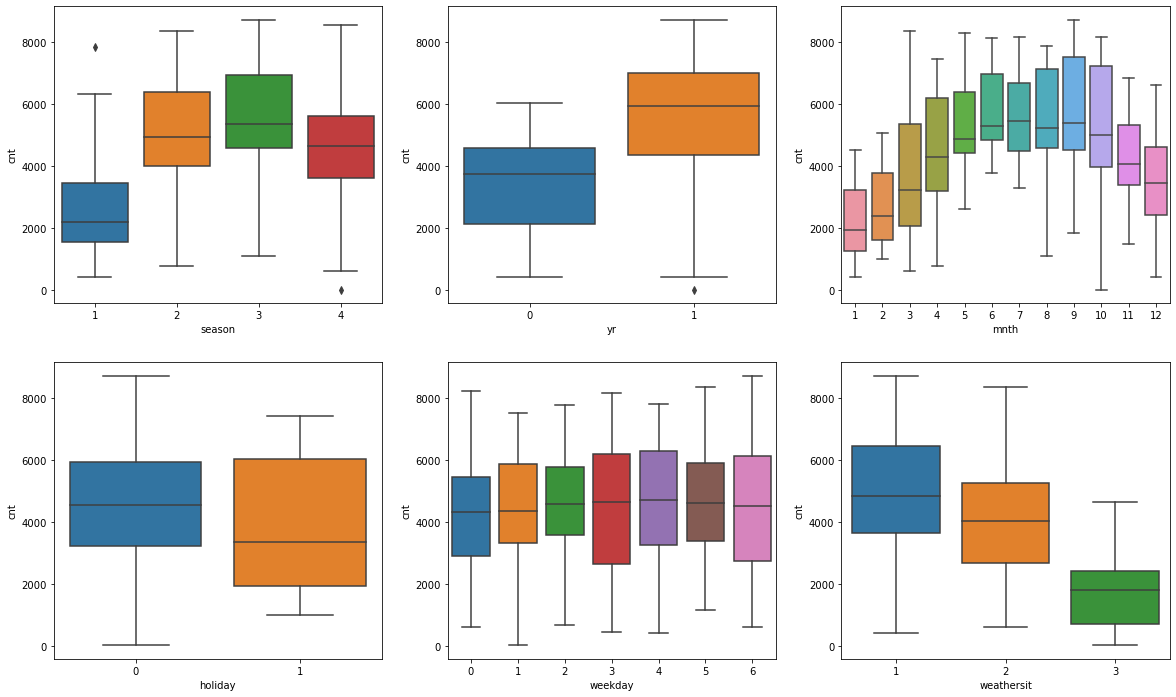

In [37]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.show()

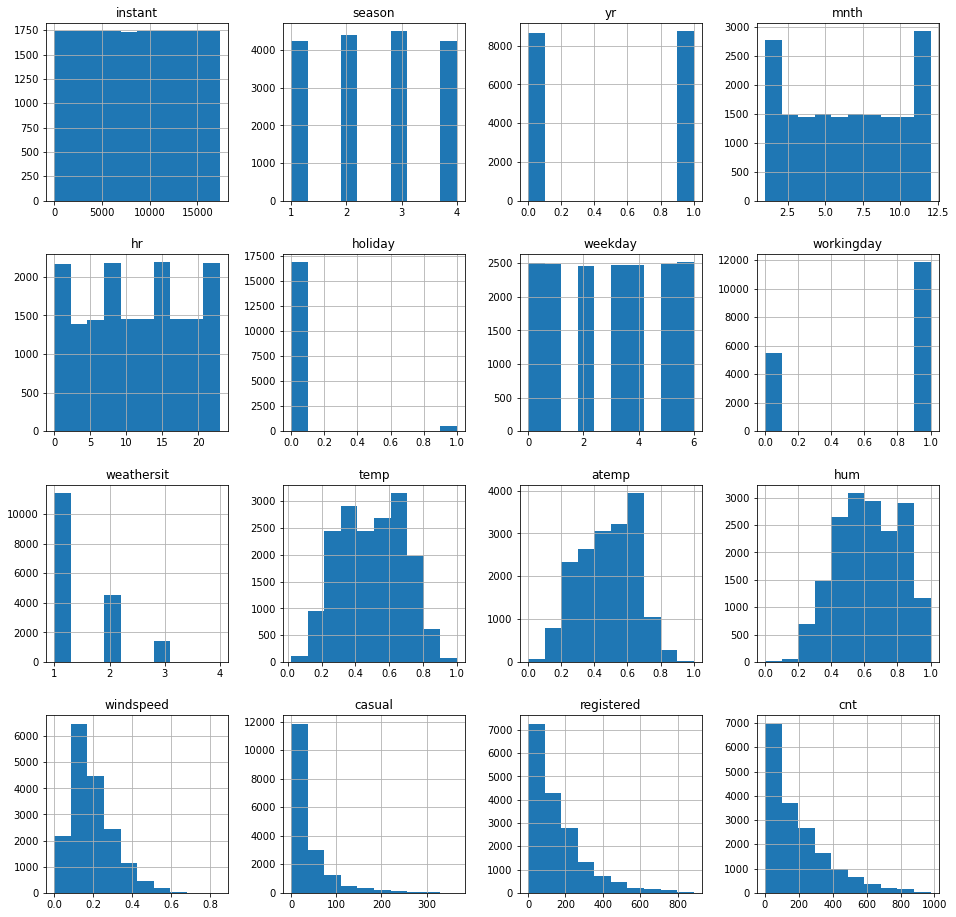

In [38]:
plt.rcParams['figure.figsize'] = (16,16)
hour.hist()
plt.show()

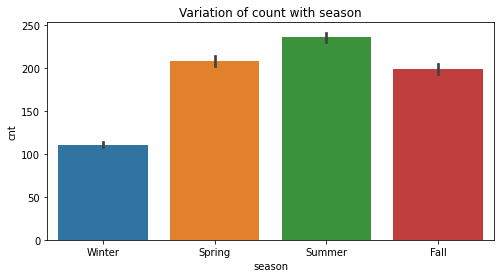

In [39]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=hour, x="season", y="cnt")
ax.set_title('Variation of count with season')

tick_val=[0,1, 2, 3]
tick_lab=['Winter', 'Spring', 'Summer', 'Fall']
plt.xticks(tick_val, tick_lab)
plt.show()

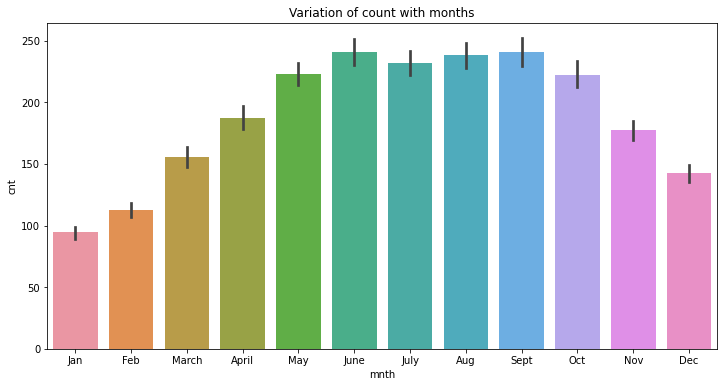

In [40]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='mnth', y='cnt', data=hour)
ax.set_title('Variation of count with months')
sns.set(style="whitegrid")

tick_val=[0,1 , 2, 3, 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11]
tick_lab=['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
plt.xticks(tick_val, tick_lab)
plt.show()

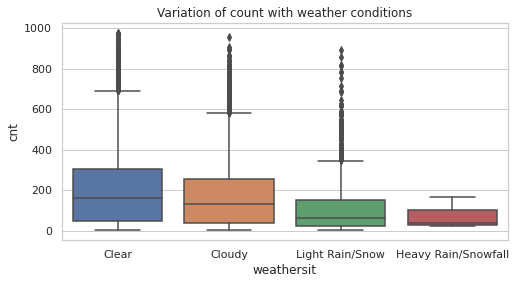

In [41]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(data=hour, x="weathersit", y="cnt")
ax.set_title('Variation of count with weather conditions')

tick_val=[0,1, 2, 3]
tick_lab=['Clear', 'Cloudy', 'Light Rain/Snow','Heavy Rain/Snowfall']
plt.xticks(tick_val, tick_lab)
plt.show()

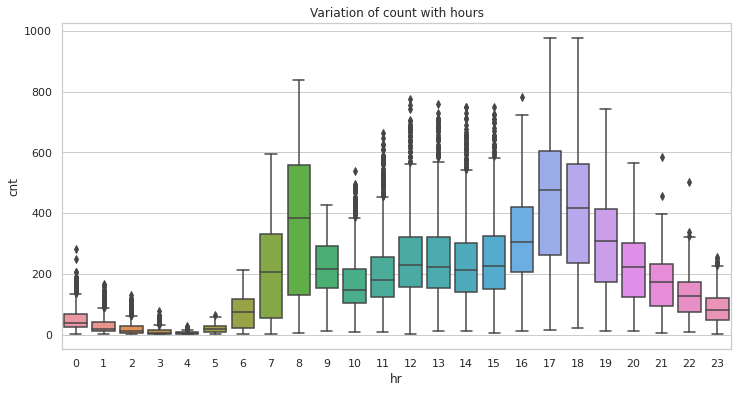

In [42]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='hr', y='cnt', data=hour)
ax.set_title('Variation of count with hours')
sns.set(style="whitegrid")

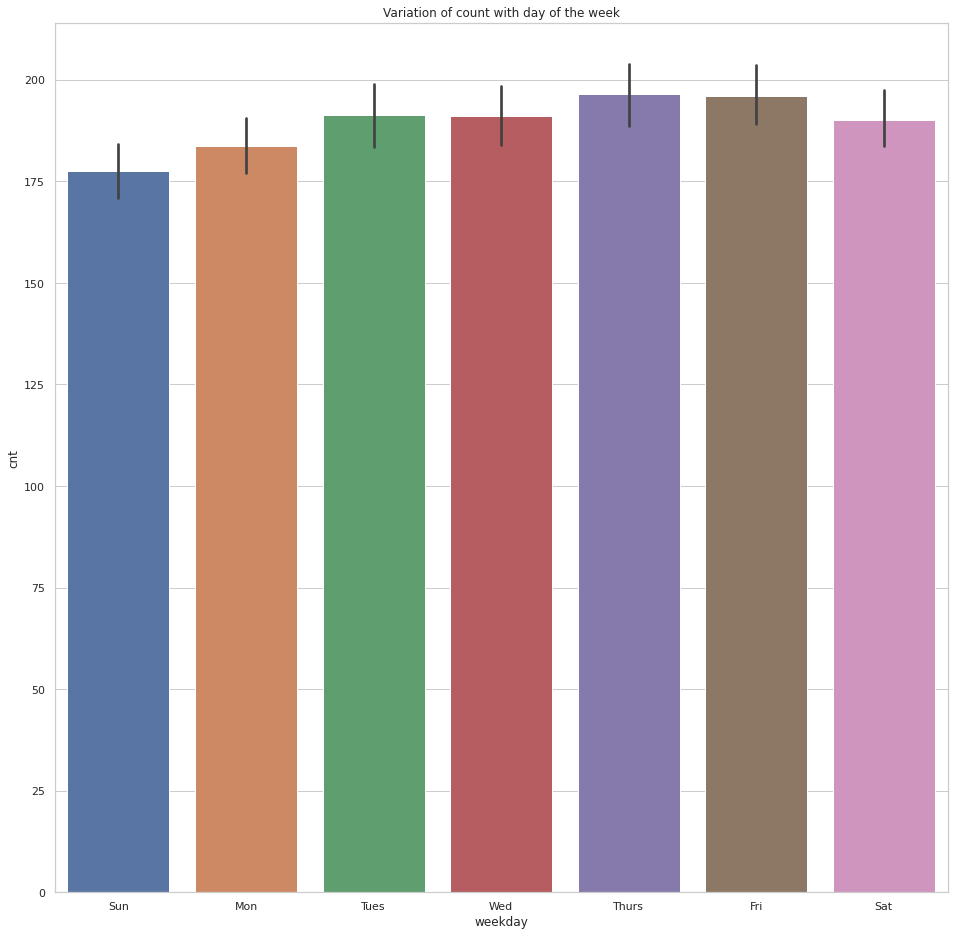

In [43]:
ax = sns.barplot(x="weekday",y='cnt',data=hour)
ax.set_title('Variation of count with day of the week')
tick_val=[0, 1, 2, 3, 4, 5, 6]
tick_lab=['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
plt.xticks(tick_val, tick_lab)
plt.show()

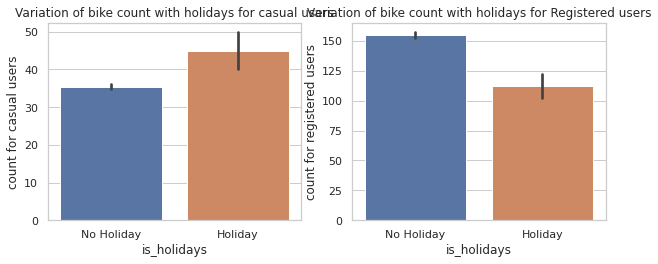

In [44]:
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
ax = sns.barplot(x="holiday",y='casual',data=hour)
plt.xlabel("is_holidays")
plt.ylabel("count for casual users")
ax.set_title('Variation of bike count with holidays for casual users')

tick_val=[0,1]
tick_lab=['No Holiday','Holiday']
plt.xticks(tick_val, tick_lab)

plt.subplot(2, 2, 2)
ax = sns.barplot(x="holiday",y='registered',data=hour)
plt.xlabel("is_holidays")
plt.ylabel("count for registered users")
ax.set_title('Variation of bike count with holidays for Registered users')

tick_val=[0,1]
tick_lab=['No Holiday','Holiday']
plt.xticks(tick_val, tick_lab)
plt.show()

/home/zhaoy426/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cnt', ylabel='Density'>

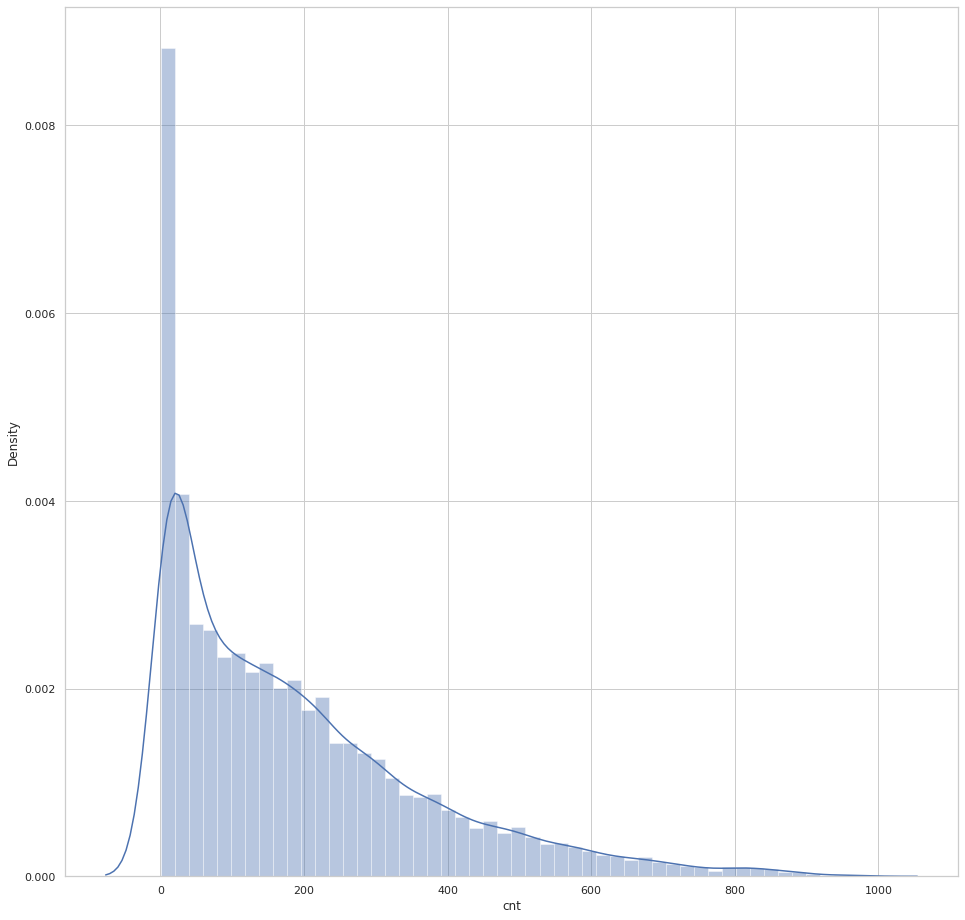

In [45]:
# Count column looks skew.
sns.distplot(hour['cnt'])

In [46]:
# Take a log for count column
hour['cnt'] = np.log1p(hour['cnt'])

/home/zhaoy426/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cnt', ylabel='Density'>

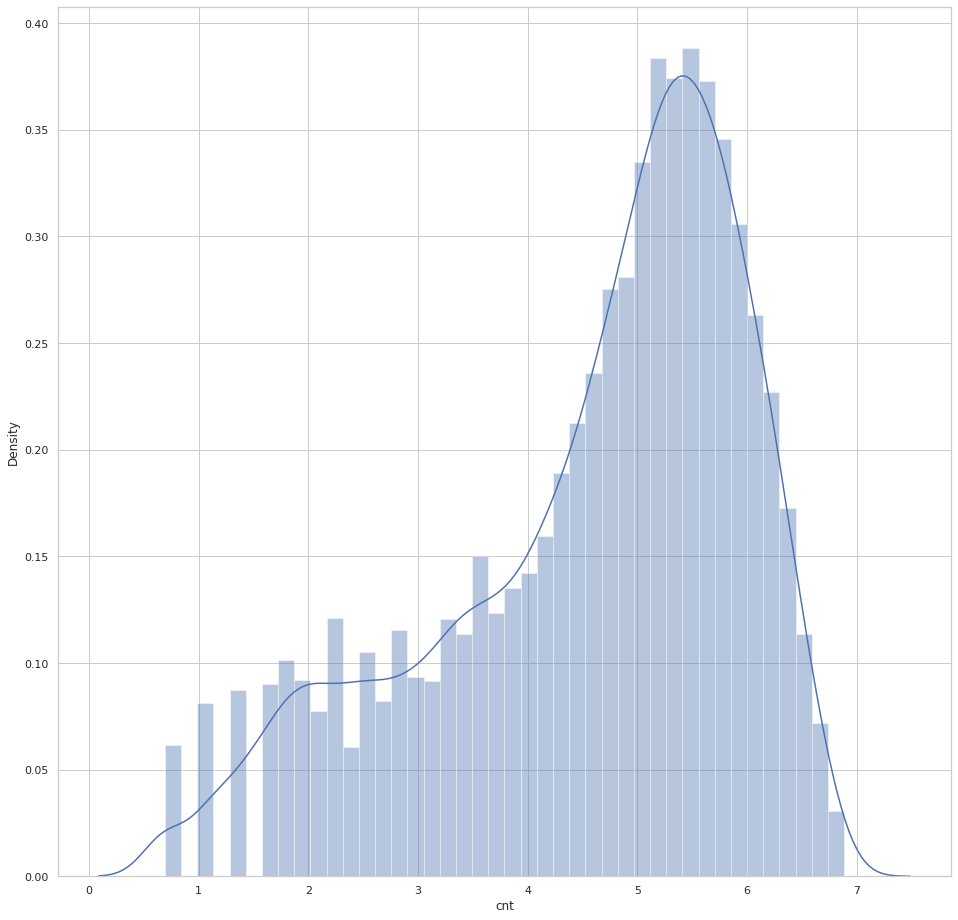

In [47]:
sns.distplot(hour['cnt'])

In [48]:
print(hour.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered       cnt  
0           1  0.24  0.2879  0.81        0.0       3          13  2.833213  
1           1  0.22  0.2727  0.80        0.0       8          32  3.713572  
2           1  0.22  0.2727  0.80        0.0       5          27  3.496508  
3           1  0.24  0.2879  0.75        0.0       3          10  2.639057  
4           1  0.24  0.2879  0.75        0.0       0           1  0.693147  


## Feature Engineering

In [49]:
# Renaming columns names to more readable names
hour.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

###########################
# Setting proper data types
###########################
# date time conversion
hour['datetime'] = pd.to_datetime(hour.datetime)

# categorical variables
hour['season'] = hour.season.astype('category')
hour['is_holiday'] = hour.is_holiday.astype('category')
hour['weekday'] = hour.weekday.astype('category')
hour['weather_condition'] = hour.weather_condition.astype('category')
hour['is_workingday'] = hour.is_workingday.astype('category')
hour['month'] = hour.month.astype('category')
hour['year'] = hour.year.astype('category')
hour['hour'] = hour.hour.astype('category')

In [50]:
# Defining categorical variables encoder method
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [51]:
# Divide the dataset into training and testing sets
X, X_test, y, y_test = train_test_split(hour.iloc[:,0:-3],
                                        hour.iloc[:,-1],
                                        test_size=0.2,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [52]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed',
                        'hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

###############
# Train dataset
###############
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

##############
# Test dataset
##############
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Train dataset shape::(13903, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.20      0.55     0.2239   11       6     1    0       1.0       0.0   
1  0.52      0.42     0.1045   18       2    10    0       0.0       0.0   
2  0.46      1.00     0.2239    3       3    12    0       0.0       0.0   
3  0.46      0.31     0.0000   18       0     4    0       0.0       1.0   
4  0.20      0.75     0.1045    6       0    12    0       1.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       0.0       0.0           1.0           0.0                  1.0   
1       0.0       1.0           1.0           0.0                  1.0   
2       0.0       1.0           1.0           0.0                  0.0   
3       0.0       0.0           1.0           0.0                  0.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4 

## Modeling

In [53]:
# Constructing train dataset
X = train_df_new
y= y.total_count.values.reshape(-1,1)

# Constructing test dataset
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
print(X.shape,y.shape)

(13903, 19) (13903, 1)


### Linear Regression

In [55]:
startTime1 = time.time()

linearRegressor = LinearRegression()
linearRegressor.fit(X, y)
 
duration1 = time.time() - startTime1

y_predicted = linearRegressor.predict(X_test)
mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
mae = mean_absolute_error(y_test,y_predicted)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_predicted))

print("Mean Squared Error:",mse)
print("R squared score:",r2)
print("Mean Absolute Error:",mae)
print('RMSLE: ', rmsle)
print()
print('Fit duration time for liear regression model is :', duration1)

Mean Squared Error: 1.0011882142444333
R squared score: 0.49147861482493826
Mean Absolute Error: 0.7894450670217972
RMSLE:  0.22854511131149743

Fit duration time for liear regression model is : 0.6457703113555908


### Decision Tree

In [64]:

startTime2 = time.time()

dtm = DecisionTreeRegressor(max_depth=5,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X,y)
duration2 = time.time()-startTime2



dtm.fit(X_test,y_test)  
y_predicted = dtm.predict(X_test)
mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test,y_predicted)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_predicted))

print("R-Squared in train data={}".format(dtm.score(X,y)))
print("R-Squared in test data={}".format(dtm.score(X_test,y_test)))
print("MSE in test data: ", mse)
print('MAE in test data: ', mae)
print('RMSLE in test data: ', rmsle)
print('Fit time', duration2)

R-Squared in train data=0.7267995602920961
R-Squared in test data=0.7330409197863536
MSE in test data:  0.525594975132512
MAE in test data:  0.5584150015986287
RMSLE in test data:  0.1557756098729682
Fit time 0.14822864532470703


In [57]:
extracted_MSEs = dtm.tree_.impurity # The Hidden magic is HERE

rmse_total=0
mse_total=0
for idx, MSE in enumerate(dtm.tree_.impurity):
    rmse_total = rmse_total + np.sqrt(MSE)
    mse_total = mse_total + MSE
    print("Node {} has MSE {}".format(idx,MSE))
#print('RMSE: ', rmse_total/len(dtm.tree_.impurity))
print('MSE: ', mse_total/len(dtm.tree_.impurity))

Node 0 has MSE 1.9688222431387743
Node 1 has MSE 1.1345558417507933
Node 2 has MSE 0.7768711895422555
Node 3 has MSE 0.8301696099350622
Node 4 has MSE 0.5073893322080565
Node 5 has MSE 0.7908843849119656
Node 6 has MSE 0.8668879016189122
Node 7 has MSE 0.35443724229995155
Node 8 has MSE 0.652212018975959
Node 9 has MSE 0.8689190301497902
Node 10 has MSE 0.6825462710152834
Node 11 has MSE 0.46265014905697655
Node 12 has MSE 0.5686012659476152
Node 13 has MSE 1.0082132033122058
Node 14 has MSE 0.6529701348010093
Node 15 has MSE 0.31223237159141615
Node 16 has MSE 0.47231798303401895
Node 17 has MSE 0.5387400235313748
Node 18 has MSE 0.3844043153702206
MSE:  0.7280960269574548


## Hyperparameter tuning with GridSearchCV

### Decision Tree

In [65]:
# This may take some time...
startTime_cv = time.time()
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100]
              }


grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X,y)
duration_cv = time.time() - startTime_cv

print('Time for grid search: ', duration_cv)

Time for grid search:  1725.5123522281647


In [59]:
print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.8827411902044228
Best Hyperparameters::
{'criterion': 'mae', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [60]:
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037338,0.045068,0.004258,0.000695,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
1,0.011743,0.000282,0.003479,0.000118,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
2,0.012045,0.000408,0.003594,0.000290,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
3,0.011947,0.000221,0.003430,0.000099,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,109
4,0.012101,0.000227,0.003443,0.000085,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,109


In [61]:
# Checking the training model scores
r2_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

avg R-squared::0.884
MSE::-0.234


### Test dataset evaludatioin

In [63]:
best_dtm_model = grid_cv_dtm.best_estimator_

y_pred = best_dtm_model.predict(X_test)
residuals = y_test.flatten() - y_pred


r2_score_dt = best_dtm_model.score(X_test,y_test)
mae_dt = mean_absolute_error(y_test,y_pred)
rmsle_dt = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("R-squared for the best DT model:{:.3f}".format(r2_score_dt))
print("MSE: %.3f" % metrics.mean_squared_error(y_test, y_pred))
print('MAE: %.3f' %mae_dt)
print('RMSLE: %.3f' %rmsle_dt)

R-squared for the best DT model:0.883
MSE: 0.231
MAE: 0.340
RMSLE: 0.112


## Analyze data with PySpark

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)
from pyspark import *                                                                                                               


#df = spark.read.csv("/home/zhaoy426/FP/data/hour.csv", header="true", inferSchema="true")
# The following command caches the DataFrame in memory. This improves performance since subsequent calls to the DataFrame can read from memory instead of re-reading the data from disk.
#df.cache()

In [2]:
# read data and save header in a different file
rawdata = sc.textFile ('/home/zhaoy426/FP/data/hour.csv')
header = rawdata.first()
print(header)

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [3]:
# delete the header line in 'hour' data
rdata = rawdata.filter(lambda x: x!=header)
print(rdata)

PythonRDD[3] at RDD at PythonRDD.scala:53


In [4]:
# check the first five rows
print(rdata.take(5))

['1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16', '2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40', '3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32', '4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13', '5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1']


In [5]:
# splite the rows by comma
records = rdata.map(lambda x: x.split(','))
first = records.first()
print('The dataset has '+str(records.count())+' rows.')

The dataset has 17379 rows.


In [6]:
records.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

In [7]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [8]:
print ("Mapping of first categorical feasture column: %s" % get_mapping(records, 2))

Mapping of first categorical feasture column: {'1': 0, '4': 1, '2': 2, '3': 3}


In [9]:
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

In [10]:
print ("Feature vector length for categorical features: %d" % cat_len)
print ("Feature vector length for numerical features: %d" % num_len)
print ("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


## Creating feature vectors for the linear model
The next step is to use our extracted mappings to convert the categorical features to binary-encoded features. Again, it will be helpful to create a function that we can apply to each record in our dataset for this purpose. We will also create a function to extract the target variable from each record. We will need to import numpy for linear algebra utilities and MLlib's LabeledPoint class to wrap our feature vectors and target variables:

In [11]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [12]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

In [13]:
def extract_label(records):
    return float(records[-1])

In [14]:
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

## Split train & Test Data

In [15]:
#data_log = records.map(lambda r: LabeledPoint(np.log(extract_label(r)), extract_features(r)))

In [16]:
train_test_data_split = data.randomSplit([0.8, 0.2],42)

train = train_test_data_split[0]
test = train_test_data_split[1]
print("Training set size is: ", train.count())
print("Test set size is : ", test.count())

Training set size is:  13953
Test set size is :  3426


In [17]:
first_point = train.first()
print ("Training data: " + str(first[2:]))
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Training data: ['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


## Creating feature vectors for the decision tree
As we have seen, decision tree models typically work on raw features (that is, it is not required to convert categorical features into a binary vector encoding; they can, instead, be used directly). Therefore, we will create a separate function to extract the decision tree feature vector, which simply converts all the values to floats and wraps them in a numpy array:

In [18]:
def extract_features_dt(record):
    #return np.array(map(float, record[2:14]))
    return np.array([float(field) for field in record[2:14]])

In [19]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))
train_test_data_dt_split = data_dt.randomSplit([0.8, 0.2],123)
train_dt = train_test_data_dt_split[0]
test_dt = train_test_data_dt_split[1]
print('Training data size for DT: ', train_dt.count())
print('Test data size for DT: ', test_dt.count())

first_point_dt = train_dt.first()
print ("Decision Tree feature vector: " + str(first_point_dt.features))
print ("Decision Tree feature vector length: " + str(len(first_point_dt.features)))

Training data size for DT:  13878
Test data size for DT:  3501
Decision Tree feature vector: [1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0]
Decision Tree feature vector length: 12


## Training and using regression models
Training for regression models using decision trees and linear models follows the same procedure as for classification models. We simply pass the training data contained in a [LabeledPoint] RDD to the relevant train method. Note that in Scala, if we wanted to customize the various model parameters (such as regularization and step size for the SGD optimizer), we are required to instantiate a new model instance and use the optimizer field to access these available parameter setters.

In [20]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
#help(LinearRegressionWithSGD.train)

In [21]:
#help(DecisionTree.trainRegressor)

## Training a regression model on the bike sharing dataset
We're ready to use the features we have extracted to train our models on the bike sharing data. First, we'll train the linear regression model and take a look at the first few predictions that the model makes on the data:

In [22]:
import time
startTime = time.time()

linear_model = LinearRegressionWithSGD.train(train, iterations=10,step=0.1, intercept=True,)

duration = time.time() - startTime
print('It takes ', round(duration, 3), 's for training a regression model.')

It takes  5.197 s for training a regression model.


Note that we have not used the default settings for iterations and step here. We've changed the number of iterations so that the model does not take too long to train. As for the step size, you will see why this has been changed from the default a little later. You will see the following output:

In [23]:
train_true_vs_predicted = train.map(lambda p: (p.label, linear_model.predict(p.features)))
test_label_vs_predicted = test.map(lambda p: (p.label, linear_model.predict(p.features)))
print ("Linear Model predictions with Training data: " + str(train_true_vs_predicted.take(5)))
print ("Linear Model predictions with Test data: " + str(test_label_vs_predicted.take(5)))

Linear Model predictions with Training data: [(16.0, 133.7774532372653), (40.0, 132.32035348341907), (32.0, 132.15404948065805), (13.0, 131.86616131251571), (1.0, 131.6927055917107)]
Linear Model predictions with Test data: [(14.0, 139.83822691798082), (56.0, 143.5933194270156), (110.0, 148.43177785930908), (37.0, 150.46621866199337), (34.0, 146.07859120445653)]


Next, we will train the decision tree model simply using the default arguments to the trainRegressor method (which equates to using a tree depth of 5). Note that we need to pass in the other form of the dataset, data_dt , that we created from the raw feature values (as opposed to the binary encoded features that we used for the preceding linear model). We also need to pass in an argument for categoricalFeaturesInfo . This is a dictionary that maps the categorical feature index to the number of categories for the feature. If a feature is not in this mapping, it will be treated as continuous. For our purposes, we will leave this as is, passing in an empty mapping:

In [24]:
startTime_dt = time.time()

dt_model = DecisionTree.trainRegressor(train_dt,{},maxDepth=5, maxBins=32)


duration_dt = time.time() - startTime_dt
print('It takes ', round(duration, 3), 's for training a Decision Tree model.')

train_preds = dt_model.predict(train_dt.map(lambda p: p.features))
train_actual = train_dt.map(lambda p: p.label)
train_true_vs_predicted_dt = train_actual.zip(train_preds)

test_preds = dt_model.predict(test_dt.map(lambda p: p.features))
test_actual = test_dt.map(lambda p: p.label)
test_true_vs_predicted_dt = test_actual.zip(test_preds)
print ("Decision Tree predictions: " + str(train_true_vs_predicted_dt.take(5)))
print ("Decision Tree depth: " + str(dt_model.depth()))
print ("Decision Tree number of nodes: " + str(dt_model.numNodes()))

It takes  5.197 s for training a Decision Tree model.
Decision Tree predictions: [(40.0, 56.71707317073171), (32.0, 52.88333333333333), (13.0, 14.6672760511883), (1.0, 14.6672760511883), (1.0, 14.6672760511883)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


## Evaluating the performance of regression models

In [25]:
from pyspark.mllib.evaluation import RegressionMetrics

def MSE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label))
    #rmse = np.sqrt(predict_real.map(lambda p: (p[0] - p[1])**2).sum() / predict_real.count())
    mse = predict_real.map(lambda p: (p[0] - p[1])**2).sum() / predict_real.count()
    return mse

def MAE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label)) 
    mae = (predict_real.map(lambda p: np.abs(p[0] - p[1]))).mean()
    return mae

# root mean squre log error
def RMSLE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label)) 
    rmsle = (predict_real.map(lambda p: (np.log(p[0]+1) - np.log(p[1]+1))**2)).mean()
    return rmsle

def metrics(model, data):
    #predict = model.predict(data.map(lambda p: p.features))
    #predict_real = predict.zip(data.map(lambda p:p.label)) 
    #metrics = RegressionMetrics(predict_real)
    #r2=metrics.r2
    predictions_observations = data \
                      .map(lambda p : (float(model.predict(p.features)), p.label)).cache()
    r2 = RegressionMetrics(predictions_observations).r2
    return r2

def dt_r2(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predictions_observations = predict.zip(data.map(lambda p:p.label))
    r2 = RegressionMetrics(predictions_observations).r2
    return r2


In [26]:
r2 = metrics(linear_model, train)
mse = MSE(linear_model, train)
mae = MAE(linear_model, train)
rmsle = RMSLE(linear_model, train)

print('Linear Model - R squared in training data: %2.4f' %r2)
print('Linear Model - Mean Squared Error in training data: %2.4f' %mse)
print('Linear Model - Mean Absolute Error in training data: %2.4f' %mae)
print('Linear Model - Root Mean Squared Log Error in training data: %2.4f' %rmsle)

Linear Model - R squared in training data: 0.0828
Linear Model - Mean Squared Error in training data: 30358.7810
Linear Model - Mean Absolute Error in training data: 132.7895
Linear Model - Root Mean Squared Log Error in training data: 2.2375


In [27]:
r2 = metrics(linear_model, test)
mse = MSE(linear_model, test)
mae = MAE(linear_model, test)
rmsle = RMSLE(linear_model, test)

print('Linear Model - R squared: %2.4f' %r2)
print('Linear Model - Mean Squared Error in Test data: %2.4f' %mse)
print('Linear Model - Mean Absolute Error in Test data: %2.4f' %mae)
print('Linear Model - Root Mean Squared Log Error in Test data: %2.4f' %rmsle)

Linear Model - R squared: 0.0863
Linear Model - Mean Squared Error in Test data: 29305.0559
Linear Model - Mean Absolute Error in Test data: 131.5691
Linear Model - Root Mean Squared Log Error in Test data: 2.3192


## Evaluating the performance of Decision Tree models

In [28]:
r2 = dt_r2(dt_model, test_dt)
mse = MSE(dt_model, test_dt)
mae = MAE(dt_model, test_dt)
rmsle = RMSLE(dt_model, test_dt)


print('Decision Tree - R squared: %2.4f' %r2)
print('Decision Tree - Mean Squared Error in Test data: %2.4f' %mse)
print('Decision Tree - Mean Absolute Error in Test data: %2.4f' %mae)
print('Decision Tree - Root Mean Squared Log Error in Test data: %2.4f' %rmsle)

Decision Tree - R squared: 0.6401
Decision Tree - Mean Squared Error in Test data: 11637.7830
Decision Tree - Mean Absolute Error in Test data: 71.1915
Decision Tree - Root Mean Squared Log Error in Test data: 0.3860


# References
https://docs.databricks.com/_static/notebooks/gbt-regression.html
https://www.kaggle.com/tboyle10/capital-bikeshare-exploratory-analysis
https://blog.csdn.net/u013719780/article/details/51822346
https://github.com/shaw-anugya/Bike-Sharing-Demand/blob/master/Bike%20Sharing%20Demand.ipynb
https://www.kaggle.com/marklvl/decision-tree-regressor-on-bike-sharing-dataset

https://stackoverflow.com/questions/27416296/how-to-push-a-csv-data-to-mongodb-using-python/56241768